In [1]:
import pandas as pd
import numpy as np
from Fingerprint.Hash2BitManager       import Hash2Bits, FindBitLength, GenerateFpsArray
from Kernels.Kernel          import funcTanimotoKernel_MMPKernel, funcTanimotoSklearn
from functools import partial
from Similarity.SimilarityHist import flattenTC
import seaborn as sns
import os
from scipy.special import rel_entr

def assign_vals(table, cols, new_col):
    for i, c in enumerate(cols):
        new_c = new_col[i]
        table[new_c] = 0
        for tid in table.index:
            data = pd.read_csv('./Dataset/Data/%s.tsv'%tid, sep='\t', index_col=0)
            table.loc[tid, new_c] = data[c].max()

    return table

def MakeSimilarityHistogram(target, use_zero=True, core_only=True, del_zero=True):
    df_tlist = pd.read_csv('./Dataset/target_list.tsv', sep='\t', index_col='chembl_tid') 
    df_main = pd.read_csv('./Dataset/Data/%s.tsv'%target, sep='\t', index_col=0)
    df_ecfp = pd.read_csv('./Dataset/ECFP/%s.tsv'%target, sep='\t', index_col=0)

    len_c = FindBitLength(df_ecfp, ['core'])
    len_s = FindBitLength(df_ecfp, ['sub1', 'sub2', 'overlap'])

    mms = df_ecfp.loc[df_main.drop_duplicates(['core_id']).index,:]

    fpgen = Hash2Bits()
    
    if not core_only:
        fp = GenerateFpsArray(mms['core'], nbits=len_c) 
        mat = funcTanimotoSklearn(fp, fp)
        sim = flattenTC(mat)
        
    else:
        fp = fpgen.GetMMPfingerprints_DF_unfold(df_ecfp, ['core', 'sub1', 'sub2', 'overlap'], nbits=[len_c, len_s], overlap='concat')
        simfunc = partial(funcTanimotoKernel_MMPKernel, len_c=len_c)
        mat = simfunc(fp,fp)
        sim = flattenTC(mat)
    
    sim = np.array(sim)
    
    if del_zero:
        sim  = sim[np.where(sim>0)[0]]
        bins = [0.00000001] + [0.1*i for i in range(1, 10)]
    
    else:
        bins = [0.1*i for i in range(10)]
        
    hist = np.histogram(sim, bins=bins, density=True)
    return hist

def kl_divergence(p, q):
	return sum(rel_entr(p,q))

def js_divergence(p, q):
    
    m = 0.5 * (p + q)
    
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)


def histogram_intersection(p, q):
    return sum([min(p_bin, q_bin) for p_bin, q_bin in zip(p, q)])

from itertools import product

def pairwise_calculation(func, labels, values):
    vals = np.array([func(i,j) for i, j in product(values, values)]).reshape(len(labels),-1)
    return pd.DataFrame(vals, index=labels, columns=labels)

In [2]:
svm = pd.read_csv('./Score_wodirection_trtssplit/SVM/mean.tsv', sep='\t', index_col=0)
rf  = pd.read_csv('./Score_wodirection_trtssplit/Random_Forest/mean.tsv', sep='\t', index_col=0)
fcn = pd.read_csv('./Score_wodirection_trtssplit/FCNN/mean.tsv', sep='\t', index_col=0)
mpn = pd.read_csv('./Score_wodirection_trtssplit/MPNN/mean.tsv', sep='\t', index_col=0)

svm = assign_vals(svm, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
rf  = assign_vals(rf , cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
fcn = assign_vals(fcn, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
mpn = assign_vals(mpn, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])

svm['model'] = 'svm'
rf['model']  = 'rf'
fcn['model'] = 'fcnn'
mpn['model'] = 'mpnn'

all_score = pd.concat([svm, rf, fcn, mpn])

In [3]:
from collections import defaultdict

rank_target = defaultdict(list)
rank_score  = defaultdict(list)

for name, ml in zip(['svm', 'rf', 'fcn', 'mpn'], [svm, rf, fcn, mpn]):
    rank_target[name] = list(ml.sort_values('matthews_coeff', ascending=False).index[:10])
    rank_score[name]  = list(ml.sort_values('matthews_coeff', ascending=False).iloc[:10,:].loc[:, 'matthews_coeff'])
    
rank_target = pd.DataFrame.from_dict(rank_target, orient='columns')
rank_score = pd.DataFrame.from_dict(rank_score, orient='columns')

In [4]:
rank_target

,svm,rf,fcn,mpn
0,CHEMBL333,CHEMBL3018,CHEMBL4523,CHEMBL333
1,CHEMBL4523,CHEMBL5407,CHEMBL204,CHEMBL204
2,CHEMBL1800,CHEMBL4523,CHEMBL5023,CHEMBL2147
3,CHEMBL5407,CHEMBL333,CHEMBL237,CHEMBL4072
4,CHEMBL2954,CHEMBL3991,CHEMBL2147,CHEMBL5407
5,CHEMBL3991,CHEMBL1741186,CHEMBL2954,CHEMBL244
6,CHEMBL2820,CHEMBL204,CHEMBL214,CHEMBL236
7,CHEMBL1926488,CHEMBL1800,CHEMBL244,CHEMBL344
8,CHEMBL204,CHEMBL2954,CHEMBL335,CHEMBL237
9,CHEMBL3729,CHEMBL4072,CHEMBL255,CHEMBL251


In [5]:
stats = pd.DataFrame(pd.Series(rank_target.values.reshape(-1)).value_counts())
stats['ml'] = ''

for target in stats.index:
    for ml in rank_target.columns:
        if any(target == rank_target[ml]):
            obj = stats.loc[target,'ml']
            stats.loc[target,'ml'] = obj + '  ' + ml

In [6]:
stats

,0,ml
CHEMBL204,4,svm rf fcn mpn
CHEMBL5407,3,svm rf mpn
CHEMBL2954,3,svm rf fcn
CHEMBL4523,3,svm rf fcn
CHEMBL333,3,svm rf mpn
CHEMBL237,2,fcn mpn
CHEMBL4072,2,rf mpn
CHEMBL1800,2,svm rf
CHEMBL2147,2,fcn mpn
CHEMBL244,2,fcn mpn


In [7]:
dict_hist = {t:MakeSimilarityHistogram(target=t, core_only=False)[0] for t in stats.index}

/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: Sett

# Compare histogram

In [8]:
classic = [1800, 3991, 3018, 1741186, 1926488, 3729, 2820]
nn_both = [244, 237]
nn_fcn  = [335, 255, 214, 5023]
nn_mpn  = [251, 236, 344]
allml   = [204, 5407, 2954, 333, 4523, 4072]

col = ['CHEMBL%d'%i for i in classic+nn_both+nn_fcn+nn_mpn+allml]

## js_divergence

In [9]:
js = pairwise_calculation(js_divergence, col, [dict_hist[c] for c in col])
js

,CHEMBL1800,CHEMBL3991,CHEMBL3018,CHEMBL1741186,CHEMBL1926488,CHEMBL3729,CHEMBL2820,CHEMBL244,CHEMBL237,CHEMBL335,...,CHEMBL5023,CHEMBL251,CHEMBL236,CHEMBL344,CHEMBL204,CHEMBL5407,CHEMBL2954,CHEMBL333,CHEMBL4523,CHEMBL4072
CHEMBL1800,0.000000,1.034453,1.258272,2.798411,0.378246,0.681892,0.216643,0.805993,0.375469,0.198570,...,0.442991,0.505306,0.522836,0.380373,0.808504,0.164544,0.457943,0.471895,0.216783,0.353792
CHEMBL3991,1.034453,0.000000,0.629651,2.976113,2.058480,0.190930,0.766599,1.430899,1.205995,1.142239,...,0.962444,1.925263,1.458931,0.858285,1.313500,0.706969,0.861686,0.760865,1.290699,0.955889
CHEMBL3018,1.258272,0.629651,0.000000,1.487627,2.127327,1.065225,1.004420,2.714948,2.111335,1.288734,...,1.732597,2.525579,2.458288,1.795062,2.625691,1.175114,1.784916,1.655207,1.766513,1.709075
CHEMBL1741186,2.798411,2.976113,1.487627,0.000000,2.850241,3.433308,2.475555,4.693333,4.094030,3.158466,...,3.966713,3.518571,4.449224,3.744996,4.625257,3.019035,3.796292,3.801114,3.332220,3.475159
CHEMBL1926488,0.378246,2.058480,2.127327,2.850241,0.000000,1.611494,0.603000,1.199665,0.801261,0.618209,...,1.056315,0.361653,0.903315,0.933461,1.248432,0.721998,1.001728,1.099944,0.439605,0.764682
CHEMBL3729,0.681892,0.190930,1.065225,3.433308,1.611494,0.000000,0.443005,0.650488,0.534788,0.732586,...,0.454310,1.186105,0.694340,0.294473,0.568976,0.290671,0.289963,0.253815,0.686728,0.387624
CHEMBL2820,0.216643,0.766599,1.004420,2.475555,0.603000,0.443005,0.000000,0.696355,0.386234,0.220373,...,0.414541,0.488483,0.541000,0.286841,0.681553,0.093932,0.270286,0.344836,0.183743,0.173350
CHEMBL244,0.805993,1.430899,2.714948,4.693333,1.199665,0.650488,0.696355,0.000000,0.120974,0.807204,...,0.366677,0.453397,0.086200,0.150452,0.007563,0.450636,0.148474,0.268641,0.350302,0.214861
CHEMBL237,0.375469,1.205995,2.111335,4.094030,0.801261,0.534788,0.386234,0.120974,0.000000,0.377556,...,0.130540,0.311318,0.021608,0.064598,0.142764,0.176823,0.089537,0.184016,0.117931,0.102131
CHEMBL335,0.198570,1.142239,1.288734,3.158466,0.618209,0.732586,0.220373,0.807204,0.377556,0.000000,...,0.346657,0.659617,0.483654,0.464491,0.834001,0.207792,0.418222,0.411338,0.210693,0.327924


In [10]:
js.to_csv('./Score_wodirection_trtssplit/similarity_hist/js_div.tsv', sep='\t')

## histogram intersection

In [11]:
hi = pairwise_calculation(histogram_intersection, col, [dict_hist[c] for c in col])
hi

,CHEMBL1800,CHEMBL3991,CHEMBL3018,CHEMBL1741186,CHEMBL1926488,CHEMBL3729,CHEMBL2820,CHEMBL244,CHEMBL237,CHEMBL335,...,CHEMBL5023,CHEMBL251,CHEMBL236,CHEMBL344,CHEMBL204,CHEMBL5407,CHEMBL2954,CHEMBL333,CHEMBL4523,CHEMBL4072
CHEMBL1800,10.000000,6.106884,5.642857,4.208333,8.398810,7.495332,8.766046,6.780277,7.727457,8.916667,...,7.888158,7.465080,7.214135,7.943606,6.937514,8.698579,7.795910,7.895605,8.339286,8.082883
CHEMBL3991,6.106884,10.000000,8.097826,3.276398,4.815218,8.228577,6.666667,4.843943,5.425532,6.023120,...,6.122807,4.471567,4.950823,6.065976,5.034535,6.577481,5.981792,6.303950,5.346847,5.824619
CHEMBL3018,5.642857,8.097826,10.000000,5.178571,4.666667,6.476833,6.257246,3.117964,4.037234,5.662699,...,5.021930,3.910861,3.527660,4.523224,3.276630,5.766165,4.538485,4.876374,4.817568,4.691722
CHEMBL1741186,4.208333,3.276398,5.178571,10.000000,4.142857,2.814464,4.472050,2.130357,2.678571,3.968254,...,2.796992,3.025233,2.432800,2.829946,2.158599,3.602484,2.781299,2.857143,3.698842,3.254852
CHEMBL1926488,8.398810,4.815218,4.666667,4.142857,10.000001,6.187068,7.753624,6.079980,6.760639,7.769842,...,6.912281,7.949900,6.474983,6.851049,6.107745,7.674471,6.766061,6.871795,7.779280,7.248701
CHEMBL3729,7.495332,8.228577,6.476833,2.814464,6.187068,10.000000,8.157316,6.578853,7.035226,7.498716,...,7.699280,6.100890,6.688166,7.712524,6.772183,8.197255,7.696538,8.002098,6.955086,7.539364
CHEMBL2820,8.766046,6.666667,6.257246,4.472050,7.753624,8.157316,10.000000,6.774066,7.721246,9.095929,...,8.108315,7.374630,7.207924,8.208007,6.931303,8.993869,8.200949,8.091655,8.351744,8.360044
CHEMBL244,6.780277,4.843943,3.117964,2.130357,6.079980,6.578853,6.774066,10.000001,8.976859,6.752526,...,7.805993,8.093748,9.395400,8.533544,9.772258,7.325905,8.557939,8.084201,8.289930,8.411521
CHEMBL237,7.727457,5.425532,4.037234,2.678571,6.760639,7.035226,7.721246,8.976859,10.000001,7.685749,...,8.692236,8.697179,9.486678,9.232362,9.041422,8.260989,9.091748,8.577567,8.979730,9.128975
CHEMBL335,8.916667,6.023120,5.662699,3.968254,7.769842,7.498716,9.095929,6.752526,7.685749,10.000000,...,8.103175,6.959421,7.285564,7.837187,6.817089,8.633143,7.947446,8.012821,8.210854,7.981582


In [12]:
hi.to_csv('./Score_wodirection_trtssplit/similarity_hist/hi_sim.tsv', sep='\t')

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap(df, outpath=None, cmap_rev=True):
    # Create a mask
    mask = None

    #Create a matplotlib colormap from the sns seagreen color palette
    cmap = sns.light_palette("blue", reverse=cmap_rev, as_cmap=True )
    # Normalize to the range of possible values from df["c"]
    norm = matplotlib.colors.Normalize(vmin=df.min().min(), vmax=df.max().max())
    # create a color dictionary (value in c : color from colormap) 
    colors = {}
    for cval in df.values.reshape(-1):
        colors.update({cval : cmap(norm(cval))})
        
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(df, mask=mask, center=0, annot=True,
                fmt='.2f', square=True, cmap=cmap)

    if outpath==None:
        plt.show()
    else:
        plt.savefig(outpath)
        
    return ax

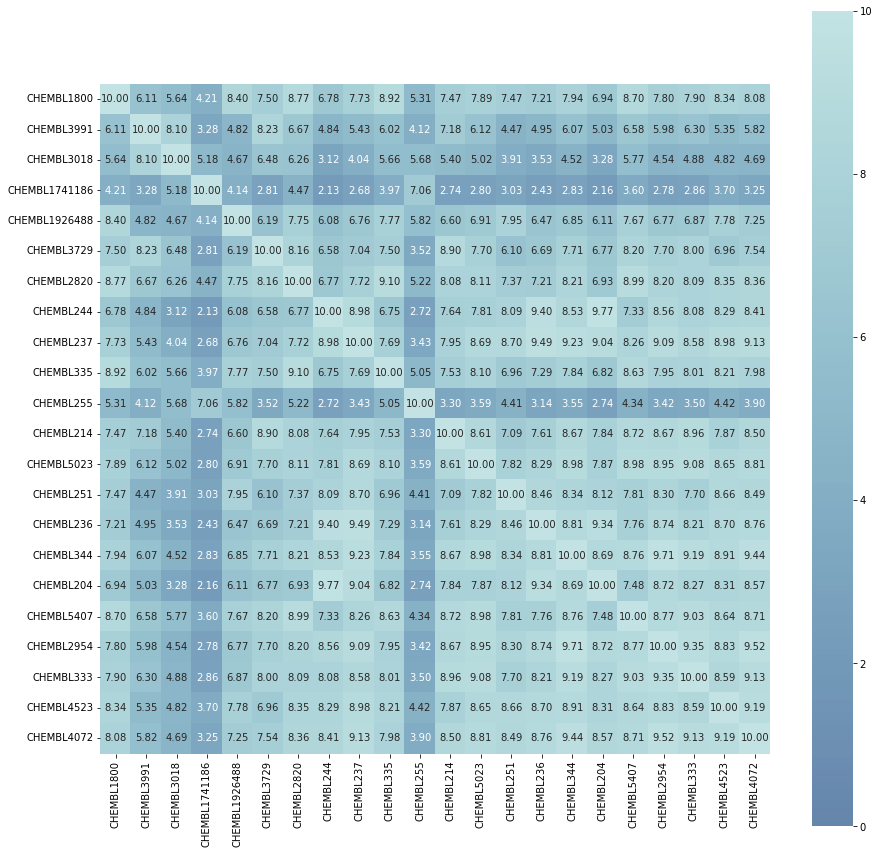

In [19]:
ax = heatmap(hi, outpath='./Score_wodirection_trtssplit/similarity_hist/heatmap_hi.svg')

In [48]:
def regional_average(val, r_from, r_to, c_from, c_to):
    
    val_sub = val[r_from:r_to, c_from:c_to]
    
    if r_from==c_from:
        ave = (val_sub.sum().sum() - np.diag(val_sub).sum()) / (val_sub.shape[0]*val_sub.shape[1]-np.diag(val_sub).shape[0])
    else:
        ave = val_sub.sum().sum() / (val_sub.shape[0]*val_sub.shape[1])
    return ave


def regional_median(val, r_from, r_to, c_from, c_to):
    
    val_sub = val[r_from:r_to, c_from:c_to]
    
    if r_from==c_from:
        triu = np.triu(val_sub,1).reshape(-1)
        med  = np.median(triu[np.where(triu>0)[0]])
    else:
        med  = np.median(val_sub.reshape(-1)) 
    return med
    

In [49]:
val = hi.values
idx = [0, 7, 16, 22]

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

6.09
5.99
6.33
5.99
7.18
7.99
6.33
7.99
8.74


In [50]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

6.19
6.47
6.82
6.47
7.83
8.53
6.82
8.53
8.72


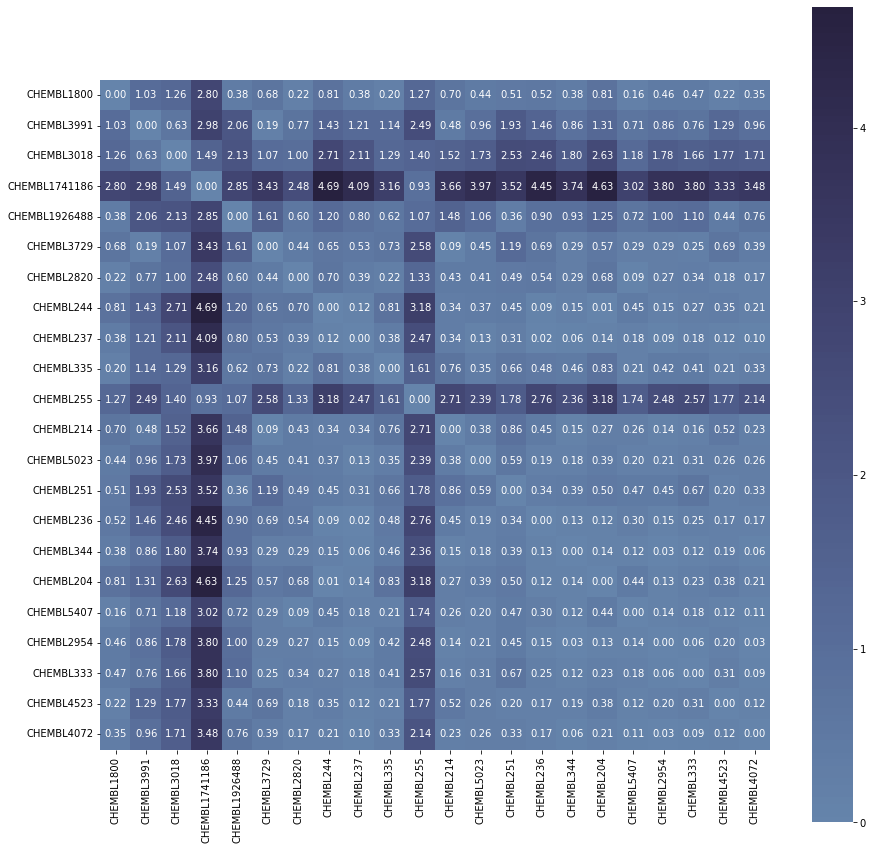

In [20]:
ax = heatmap(js, outpath='Score_wodirection_trtssplit/similarity_hist/heatmap_js.svg', cmap_rev=False)

In [51]:
val = js.values
idx = [0, 7, 16, 22]

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

1.43
1.39
1.21
1.39
0.81
0.49
1.21
0.49
0.18


In [52]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

1.07
0.96
0.76
0.96
0.39
0.24
0.76
0.24
0.14
